# ChGK and NLP

What? Where? When? (Russian: Что? Где? Когда?, translit. Chto? Gde? Kogda?) is a famous Russian intellectual game show. Besides the TV version, it also exists as a competitive game played in clubs organized by the World Association of Clubs. Over 50,000 teams worldwide play the sport version of the game (https://en.wikipedia.org/wiki/What%3F_Where%3F_When%3F)
All questions written for the game are stored in The Base (https://db.chgk.info/). I want to use it for my analysis and training of my NLP neural network. Let's start with installing some packages:

In [2]:
%pip install lxml matplotlib nltk pandas pymorphy2 sklearn wordcloud seaborn 
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [3]:
import glob
import pickle
import re
import string

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pymorphy2
import requests
import tqdm
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, MultiTaskLasso
from sklearn.model_selection import train_test_split

In [4]:
# nltk.download('stopwords')
morph = pymorphy2.MorphAnalyzer()
def normal_form(word):
    return morph.parse(word)[0].normal_form


STOPWORDS = set(stopwords.words('russian'))
STOPWORDS.update(['pic', 'jpg', 'зачет', 'незачет', 'это', 'чтецу'])
STOPWORDS.update([normal_form(w) for w in STOPWORDS])
OTHER = 'other'

authors_file = './files/authors.csv'
questions_file = './files/questions.csv'

ds_train_file = './files/ds_train.pkl'
ds_test_file = './files/ds_test.pkl'
ds_val_file = './files/ds_val.pkl'

vectorizer_file = './files/vectorizer.pkl'

In [5]:
def parse_authors(file='./files/authors.csv'):
    URLs = [
        'https://db.chgk.info/people?sort=desc&order=%D0%92%D0%BE%D0%BF%D1%80%D0%BE%D1%81%D0%BE%D0%B2',
        'https://db.chgk.info/people?page=1&sort=desc&order=%D0%92%D0%BE%D0%BF%D1%80%D0%BE%D1%81%D0%BE%D0%B2'
    ]
    authors = []
    for URL in URLs:
        page = requests.get(URL)
        soup = BeautifulSoup(page.content, 'html.parser')
        tbody = soup.find('tbody')
        trs = tbody.find_all('tr')
        for tr in trs:
            place = tr.find('td').text
            a = tr.find('a')
            href = a['href']
            name = a.text
            authors.append((place, href, name))
    authors = pd.DataFrame(authors, columns=['place', 'href', 'name'])
    authors.set_index('place', inplace=True)
    authors.to_csv(file)
    return authors

Let's get top 100 authors from The Base:

In [6]:
# authors = parse_authors()

Now let's save each author's questions of type "ChGK" starting from the year 2000; for some reason, we can't get more than 1000 questions at once

In [7]:
def get_questions_by_author(author_name):
    url = f'https://db.chgk.info/xml/search/questions/author_{author_name}/types1/QAZCU/from_2000-01-01/limit1000'
    xml_file = requests.get(url).content
    f = open(f"./files/{author_name}.xml", "wb")
    f.write(xml_file)
    f.close()

In [8]:
def get_questions(authors: pd.DataFrame):
    for _, author in tqdm.tqdm(authors.iterrows()):
        nickname = author['href'].split('/')[2]
        get_questions_by_author(nickname)

In [9]:
# get_questions(authors)

In [10]:
def get_df(file):
    xml_files = glob.glob('./files/*.xml')
    frames = []
    for xml_file in xml_files: 
        try:
            print(xml_file)
            questions = pd.read_xml(xml_file)
            questions.drop([0], inplace=True)
            questions.drop(columns=['total'], inplace=True)
            questions.insert(0, 'Author', re.split(r'\\|\.|/', xml_file)[-2])
            frames.append(questions)
        except:
            pass
    df = pd.concat(frames)
    df.to_csv(file)

We choose for prediction only top 50 authors:

In [11]:
TOP50 = pd.Series(
    ['rkhajbullin', 'bshojkhet', 'sshibanov', 'eponikarov', 'dsolovev',
     'bmonosov', 'vostrovsky', 'ityunkin', 'knaumenko', 'ivolobuev',
     'ekopejka', 'opelipejchenko', 'lgelfand', 'dborok', 'tleschenko',
     'achizhov', 'dzharkov', 'dbashuk', 'yuvymenets', 'tbarsky',
     'alkudryavtsev', 'dsarkanich', 'akorobejnikov', 'mkarpuk',
     'amatukhno', 'nkudryashova', 'acherdantsev', 'mmatveev',
     'agnoevykh', 'mperlin', 'psolakhyan', 'nfarukshin', 'mmerzlyakov',
     'apaevsky', 'pershov', 'akolesov', 'abogoslovsky', 'oneumyvakina',
     'ekalyukov', 'akuzma', 'vmyalov', 'mivanov', 'mrusso',
     'alisyansky', 'lklimovich', 'atrefilov', 'mevlanov', 'ehgolub',
     'okuzma', 'abelkin'])

In [12]:
# get_df(results_file)

Now we read and preprocess our dataframe:

In [13]:
def preprocess_tokens(text):
    text = text.lower()
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.compile('<.*?>').sub('', text)
    text = re.sub(r'\d', ' ', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    return text


def tokenize(text: str):
    tokens = word_tokenize(preprocess_tokens(text), language='russian')
    return list(map(normal_form, tokens))

def preprocess_text(text):
    text = str(text)
    text = text.strip()
    text = re.sub('\n+', ' ', text)
    text = re.sub('\\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def read_df(file) -> pd.DataFrame:
    df = pd.read_csv(file, index_col=[0])
    df['tourPlayedAt'] = pd.to_datetime(df['tourPlayedAt'])
    df = df[df['tourPlayedAt'] < '01-01-2019']
    df.loc[(~df.Author.isin(TOP50)), 'Author'] = OTHER
    df['Question'] = df['Question'].apply(lambda x: preprocess_text(x))
    df['PreprocessedQuestion'] = df['Question'].apply(
        lambda x: tokenize(x))
    df['WordCount'] = df['PreprocessedQuestion'].apply(len)
    df['PreprocessedAnswer'] = df['Answer'].apply(
        lambda x: tokenize(x))
    return df

In [14]:
# df = read_df(questions_file)
# df.head()

We need to create train-test-val split:

In [15]:
def split_df(df: pd.DataFrame):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=34)
    df_train, df_val = train_test_split(df_train, test_size=0.1,
                                        random_state=34)
    with open(ds_test_file, 'wb') as f:
        pickle.dump(df_test, f)
    with open(ds_train_file, 'wb') as f:
        pickle.dump(df_train, f)
    with open(ds_val_file, 'wb') as f:
        pickle.dump(df_val, f)

In [16]:
# split_df(df)

In [17]:
def load_datasets():
    with open(ds_train_file, 'rb') as f:
        df_train = pickle.load(f)
    with open(ds_test_file, 'rb') as f:
        df_test = pickle.load(f)
    with open(ds_val_file, 'rb') as f:
        df_val = pickle.load(f)
    return df_train, df_test, df_val

In [18]:
df_train, df_test, df_val = load_datasets()
df_train.head()

,Author,tourFileName,tournamentFileName,QuestionId,ParentId,Number,Type,TypeNum,TextId,Question,Answer,PassCriteria,Authors,Sources,Comments,Rating,RatingNumber,Complexity,Topic,ProcessedBySearch,parent_text_id,ParentTextId,tourId,tournamentId,tourTitle,tournamentTitle,tourType,tournamentType,tourPlayedAt,tournamentPlayedAt,tourPlayedAt2,tournamentPlayedAt2,Notices,PreprocessedQuestion,WordCount,PreprocessedAnswer
749,mrusso,genius04.36,genius04.txt,709583.0,42612.0,5.0,Ч,1.0,genius04.36-5,Олонецкие рыбаки называли мелкую рыбешку арест...,Рыбную молодь ловить запрещено.,NaN,Максим Руссо (Москва),"Этимология 2000-2002. - М.: Наука, 2003, стр. ...",Рыбнадзор за это может задержать рыбака.,NaN,NaN,NaN,NaN,NaN,genius04.36,genius04.36,42612.0,3389.0,116 тур,Конкурс на сайте www.genius.ru,Т,Ч,2004-09-30,2004-01-01,2004-09-30,2004-01-01,NaN,"[олонецкий, рыбак, называть, мелкий, рыбёшка, ...",19,"[рыбный, молодь, ловить, запретить]"
201,okuzma,ochki12.7,ochki12.txt,828307.0,49349.0,2.0,Ч,1.0,ochki12.7-2,"Когда шафран появился на западе, его стали наз...","Цвет, цена.",В любом порядке.,Андрей Кузьма и Ольга Кузьма (Санкт-Петербург),Джон Грант. Отвергнутая наука. Самые невероятн...,NaN,NaN,NaN,NaN,NaN,NaN,ochki12.7,ochki12.7,49349.0,1090.0,"Пятый день. ""Минное поле""",Открытый чемпионат клуба интеллектуальных игр ...,Т,Ч,2013-02-21,2012-09-20,2013-02-21,2013-02-21,NaN,"[когда, шафран, появиться, на, запад, он, стат...",24,"[цвет, цена]"
192,other,pylayu14.3,pylayu14.txt,869293.0,51434.0,14.0,Ч,1.0,pylayu14.3-14,(pic: 20140234.jpg) Эта работа Репина хранится...,Косарь.,"Литвин, косарь-литвин.","Артем Синцов, Николай Коврижных (Киров)",http://www.art-catalog.ru/picture.php?id_pictu...,"Этюд Репина называется ""КосАрь-литвин. Здравнё...",NaN,NaN,NaN,NaN,NaN,pylayu14.3,pylayu14.3,51434.0,1308.0,2 тур,"Синхронный турнир ""Пылающий июнь""",Т,Ч,2014-06-28,2014-06-28,2014-06-28,2014-06-28,NaN,"[pic, jpg, этот, работа, репин, храниться, в, ...",14,[косарь]
359,other,srediz08.4,srediz08.txt,901860.0,53529.0,5.0,Ч,1.0,srediz08.4-5,"В предисловии утверждалось, что всякий, кто хо...",Ийона Тихого.,"По фамилии, допускаются также разные варианты ...",Юрий Вашкулат (Киев),Станислав Лем. Приключения Ийона Тихого. - М.:...,"Цитата из предисловия профессора Тарантоги к ""...",NaN,NaN,NaN,NaN,NaN,srediz08.4,srediz08.4,53529.0,3609.0,3 тур,"Синхронный турнир ""Звездный мост - Кубок Среди...",Т,Ч,2008-09-13,2008-09-13,2008-09-13,2008-09-13,NaN,"[в, предисловие, утверждаться, что, всякий, кт...",44,"[ийон, тихий]"
268,psolakhyan,pechat16.2,pechat16.txt,849876.0,50238.0,10.0,Ч,1.0,pechat16.2-10,"Считается, что автору классического японского ...","""Москва - Петушки"".",NaN,Павел Солахян (Ереван),1. http://ru.wikipedia.org/wiki/Повесть_о_Гэнд...,"Глава ""Сокрытие в облаках"" дошла до наших дней...",NaN,NaN,NaN,NaN,NaN,pechat16.2,pechat16.2,50238.0,21085.0,2 тур,"Синхронный турнир ""Седьмая печать - 2016""",Т,Ч,2016-02-12,2016-02-12,2016-02-12,2016-02-12,NaN,"[считаться, что, автор, классический, японский...",47,"[москва, петушки]"


In [19]:
%pip install spacy
!python -m spacy download ru_core_news_sm

Note: you may need to restart the kernel to use updated packages.
[+] Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


2022-07-20 16:23:55.985365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-07-20 16:23:55.985396: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-20 16:23:58.731185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-07-20 16:23:58.732115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2022-07-20 16:23:58.732997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2022-07-20 16:23:58.733914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cu

Let's take look at a single question with spaCy library:

In [20]:
import spacy
from spacy import displacy

nlp = spacy.load('ru_core_news_sm')

In [21]:
text = df_train['Question'].iloc[6]
print(text)

Кеплер в 1611 году написал о них трактат. Первое их собрание опубликовал в 1665 году Роберт Гук. Первый их удачный фотопортрет создал в 1885 году Уилсон Бентли, он же создал и первую фотоколлекцию из 5000 экземпляров, а американский физик Кеннет Либбрехт все-таки научился делать их на заказ - более или менее такими, как хочется. Назовите их.


We'll look at the tokens of one sentence:

In [22]:
doc = nlp(text)
sentence = list(doc.sents)[0]
sentence

Кеплер в 1611 году написал о них трактат.

In [23]:
tokens = [[token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop] for token in sentence]
pd.DataFrame(tokens, columns=['Text', 'Lemma', 'POS', 'Tag', 'Dep', 'Shape', 'Is_Alpha', 'Is_Stop'])

,Text,Lemma,POS,Tag,Dep,Shape,Is_Alpha,Is_Stop
0,Кеплер,кеплер,PROPN,PROPN,nsubj,Xxxxx,True,False
1,в,в,ADP,ADP,case,x,True,True
2,1611,1611,ADJ,ADJ,amod,dddd,False,False
3,году,год,NOUN,NOUN,obl,xxxx,True,False
4,написал,написать,VERB,VERB,ROOT,xxxx,True,False
5,о,о,ADP,ADP,case,x,True,True
6,них,них,PRON,PRON,obl,xxx,True,True
7,трактат,трактат,NOUN,NOUN,obj,xxxx,True,False
8,.,.,PUNCT,PUNCT,punct,.,False,False


This way we can get base form, part of speech, dependency label, shape of word, if it consists of alphabetic characters and if it's a stop word  

With displacy we can visualize syntactic dependencies of the sentence:

In [24]:
displacy.render(sentence, style='dep', jupyter=True, options={'distance': 100})

Also we can visualize named entities:

In [25]:
doc.ents

(Кеплер, Роберт Гук, Уилсон Бентли, Кеннет Либбрехт)

In [26]:
colors = {"PER": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
displacy.render(doc, style="ent", options={'colors': colors}, jupyter=True)

With spaCy you can use patterns to match your data. I want to find what (or who) we have to name for each question:

In [27]:
from spacy.matcher import Matcher

In [79]:
pattern = [
    [{'NORM': 'назовите'}, {'OP': '+'}],
    [{'POS': 'ADP', 'OP': '?'}, {'LEMMA': {"IN": ["что", "кто", "где", "когда", "почему"]}}, {'IS_ALPHA': True, 'OP': '+'}, {'TEXT': '?'}],
]

In [80]:
matcher = Matcher(nlp.vocab)
matcher.add('назовите', pattern)

In [86]:
for text in df_train['Question'][:100]:
    doc_ = nlp(text)
    match = matcher(doc_)
    if match:
        print(doc_[match[-1][1]: match[-1][2]])

Назовите их.
Кого же?
Назовите это второе произведение.
Назовите их.
Назовите ЕГО тремя словами.
Назовите заглавного героя, который получил то же задание и извлек из него большую выгоду.
чем состоит это убеждение?
Назовите ЕГО двумя словами.
Назовите ЕЕ одним словом.
Назовите ЕГО двумя словами.
Назовите ИКС.
Назовите этот альбом.
Назовите ЕЕ имя и фамилию.
Назовите это государство.
Назовите ЭТО тремя словами.
Назовите максимально точно официальную роль, которую сыграл в этом сражении советский человек, оказавший влияние на его исход.
Назовите эту оперу.
Назовите ЕЕ.
Назовите ЕЕ греческим словом.
Назовите ПЕРВЫХ и ВТОРУЮ.
Назовите ЕЕ.
Назовите ИКС одним словом.
Назовите ЕГО.
Назовите ИХ тремя словами.
Назовите ЕЕ.
Назовите ЭТО.
Назовите ЕЕ имя.
Назовите ЕГО.
Назовите ПЕРВУЮ и ВТОРОЙ.
Назовите ИХ.
Назовите первое слово названия этого вида мебели.
Назовите это поселение, давно поглощенное Лондоном.
Назовите ИКС словом с ударением на втором слоге.
Назовите ИКС.
Назовите этих двоих, учитыва

Let's make some visualizations of dataset:

<AxesSubplot:xlabel='tourPlayedAt'>

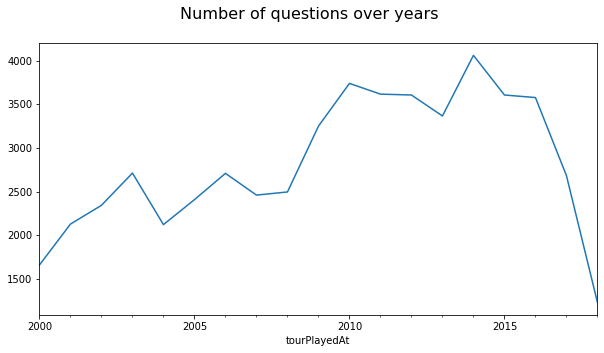

In [113]:
plt.figure(figsize=(10, 5))
q_years = df_train.groupby(pd.Grouper(key='tourPlayedAt', freq='Y')).size()
plt.suptitle('Number of questions over years', fontsize=16)
q_years.plot()   

<AxesSubplot:xlabel='Author'>

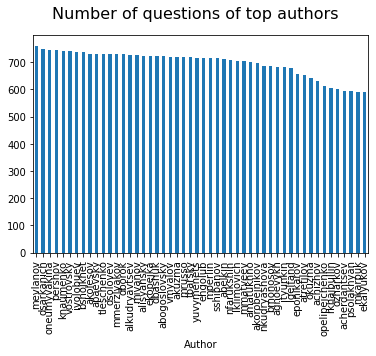

In [115]:
q_auth = df_train.groupby('Author').size().sort_values(ascending=False)[1:]
plt.suptitle('Number of questions of top authors', fontsize=16)
q_auth.plot(kind='bar')    

<AxesSubplot:xlabel='tourPlayedAt'>

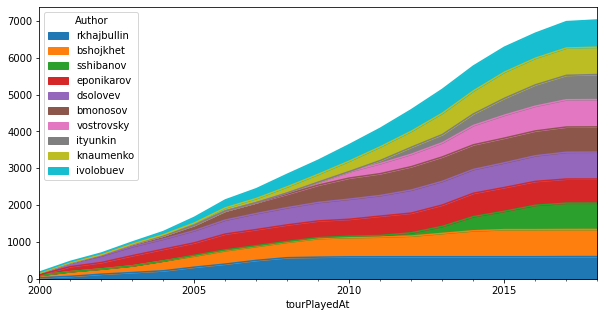

In [116]:
q_y_auth = df_train.groupby(
        ['Author',
         pd.Grouper(key='tourPlayedAt', freq='Y')]).size().unstack().fillna(
        0).cumsum(axis=1).T[TOP50[:10]]
q_y_auth.plot.area(figsize=(10, 5))

<AxesSubplot:ylabel='Frequency'>

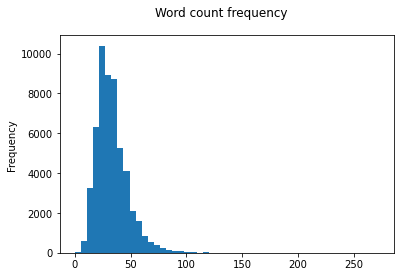

In [123]:
plt.suptitle('Word count frequency')
df_train['WordCount'].plot(kind='hist', bins=50)

<AxesSubplot:xlabel='Author'>

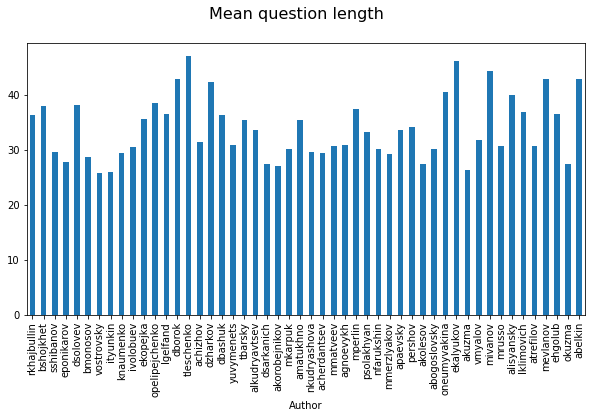

In [120]:
plt.figure(figsize=(10, 5))   
q_len = df_train.groupby('Author')['WordCount'].mean()[TOP50]
plt.suptitle('Mean question length', fontsize=16)
q_len.plot(kind='bar')

Let's look at word clouds for questions and answers:

In [20]:
from wordcloud import WordCloud

def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                          stopwords=STOPWORDS,
                          width=3000,
                          height=2500,
                          max_words=200,
                          random_state=42
                          ).generate(' '.join([' '.join(q) for q in corpus]))
    return wordCloud


def show_wordcloud(df: pd.DataFrame):
    corpus = df['PreprocessedQuestion'].values
    wc_q = get_wordCloud(corpus)
    answers = df['PreprocessedAnswer'].values
    wc_a = get_wordCloud(answers)
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(wc_q)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(wc_a)
    plt.axis('off')
    plt.show()

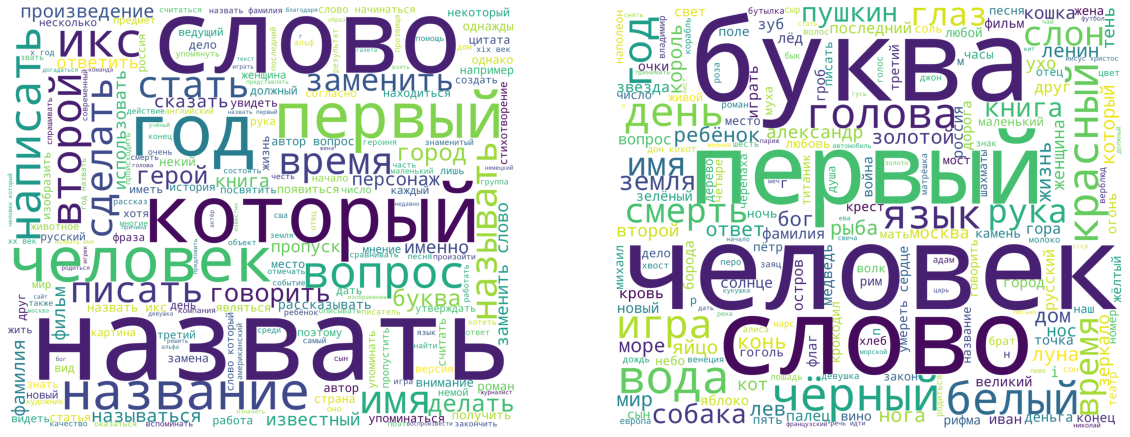

In [21]:
show_wordcloud(df_train)

As we can see, among the most frequent words in the answers are 'letter', 'man', 'word', 'first', 'black', 'white', 'water', 'game', 'red', 'language' and 'Pushkin' (of course). Now let's try to predict something, for example, the author of a question. We'll use grid search to choose the best algorithm for the task.

In [22]:
def get_ds(df: pd.DataFrame):
    return df['PreprocessedQuestion'].tolist(), df['Author'].tolist(), df['tourPlayedAt'].dt.year.tolist()

In [23]:
X_train, Y_author_train, Y_year_train = get_ds(df_train)
X_test, Y_author_test, Y_year_test = get_ds(df_test)
X_val, Y_author_val, Y_year_val = get_ds(df_val)

In [24]:
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, SGDRegressor, ElasticNet, BayesianRidge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import CategoricalNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, BaggingClassifier, BaggingRegressor
from sklearn.preprocessing import StandardScaler

In [25]:
def grid_search(X_train, Y_train, parameters_alg, algs, parameters_vec, vec, scoring='f1_macro', alg_type='clf'):
    for name, alg in algs.items():
        print(name)
        pipeline = Pipeline([
                            ('vec', TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)),
                            (alg_type, alg)
        ])
        grid = GridSearchCV(pipeline, dict(parameters_vec, **parameters_alg[name]), cv=5, n_jobs=4, scoring=scoring, verbose=True).fit(X_train, Y_train)
        print('Best score and parameter combination:')
        print(grid.best_score_, grid.best_params_)

In [26]:
classifiers = {
        'sgd': SGDClassifier(random_state=34),
        'decision tree':  DecisionTreeClassifier(random_state=34),
        'k-neighbors':  KNeighborsClassifier(),
        'random forest': RandomForestClassifier(),
    }

In [27]:
parameters_clf = {
        'sgd': {
                'clf__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge',
                         'perceptron'],
                'clf__class_weight': [None, 'balanced'],
                'clf__penalty': [None, 'l2', 'l1', 'elasticnet']
                },
        'decision tree': {
            'clf__max_depth': [200, 500, 1000, None],
            'clf__criterion': ['gini', 'entropy'],
            'clf__max_features': ['auto', 'sqrt', 'log2', None]
        },
        'k-neighbours': {
            'clf__n_neighbors': [5, 10, 20, 50],
            'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'clf__weights': ['uniform', 'distance'],
            'clf__leaf_size': [10, 30, 100],
        },
        'random forest': {
            'clf__n_estimators': [10, 50, 100],
            'clf__max_depth': [None, 100, 1000, 5000],
            'clf__class_weight': [None, 'balanced', 'balanced_subsample']
        }
        
    }

vectorizer = TfidfVectorizer()
parameters_vec =  {
        'vec__max_features': [None],
        'vec__ngram_range': [(1, 2)]
    }

In [28]:
# grid_search(X_train, Y_author_train, parameters_clf, classifiers, parameters_vec, vectorizer, scoring='f1_macro')

In [29]:
best_parameters = {
        'sgd': {'clf__class_weight': 'balanced', 'clf__loss': 'modified_huber', 'clf__penalty': 'l2', 'clf__max_iter': 100, 'vec__ngram_range': (1, 2)},
        'decision tree': {'clf__criterion': 'gini', 'clf__max_depth': 500, 'clf__max_features': None, 'vec__max_features': None, 'vec__ngram_range': (1, 2)},
        'k-neighbors': {'clf__algorithm': 'auto', 'clf__leaf_size': 10, 'clf__n_neighbors': 5},
        'random forest': {'clf__class_weight': 'balanced', 'clf__max_depth': 100, 'clf__n_estimators': 100, 'vec__max_features': None, 'vec__ngram_range': (1, 2)}
    }

In [30]:
def classify(X_train, Y_train, X_test, Y_test, alg='sgd'):
    pipeline = Pipeline([
                            ('vec', TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)),
                            ('clf', classifiers[alg])
        
        ])
    pipeline.set_params(**best_parameters[alg])
    pipeline.fit(X_train, Y_train)
    predicted = pipeline.predict(X_test)
    clf_report = metrics.classification_report(predicted, Y_test, output_dict=True)
    plt.figure(figsize=(5, 15))
    plt.suptitle('Classification report heatmap', fontsize=16)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

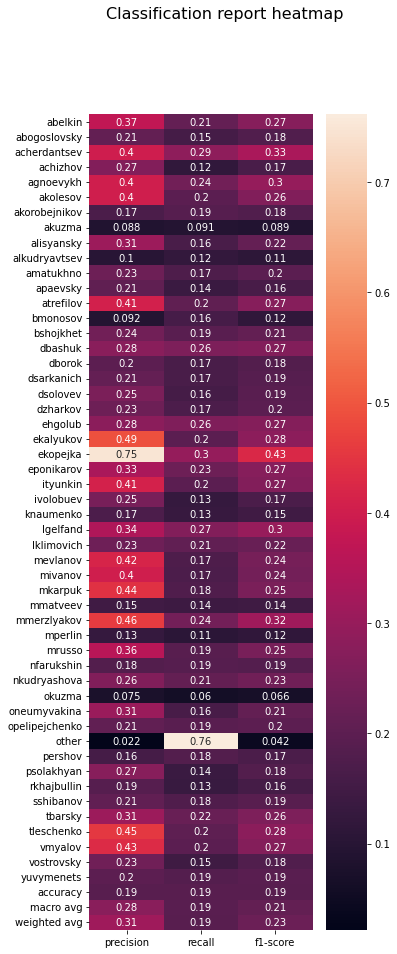

In [31]:
best_alg = 'sgd'
classify(X_train, Y_author_train, X_test, Y_author_test, best_alg)

Not so great, but we can see a few distinguished authors. Let's look at the questions of Evgeny Kopejka:

In [32]:
df_train[df_train['Author'] == 'ekopejka']['tourPlayedAt'].describe(datetime_is_numeric=True)

count                              721
mean     2001-06-08 09:45:11.234396672
min                2000-01-01 00:00:00
25%                2000-01-01 00:00:00
50%                2002-01-01 00:00:00
75%                2002-01-01 00:00:00
max                2004-07-03 00:00:00
Name: tourPlayedAt, dtype: object

All his questions were written before 2005; we can assume that the questions of 2000-s differ a lot from the nowadays' ones. Maybe we can predict the year of the question using regression?

In [33]:
regressors = {
            'linear': LinearRegression(),    
            'ridge': Ridge(random_state=34, max_iter=100),
            'lasso': Lasso(),
            'elastic': ElasticNet(max_iter=100),
            'kernel ridge': KernelRidge(),
            'gradient boost': GradientBoostingRegressor(verbose=True),
            'bagging': BaggingRegressor(verbose=True, n_jobs=4, random_state=34),
             }
parameters_reg = {
    'linear': {
                'reg__normalize': [True, False],
                'reg__fit_intercept': [True, False]
                },
    'ridge': {
        'reg__alpha': [0.1, 0.5, 1.0],
        'reg__solver': ['auto', 'sparse_cg', 'sag', 'lbfgs']
    },
    'lasso': {},
    'elastic': {
        'reg__alpha': [0.1, 0.5, 1.0],
        'reg__l1_ratio': [0.25, 0.5, 0.75],
        'reg__tol': [1e-6, 1e-4, 1e-3],
        'reg__selection': ['cyclic', 'random']
    },
    'kernel ridge': {
            'reg__alpha': [0.1, 0.5, 0.75, 1.0],
            'reg__kernel': ['linear', 'additive_chi2', 'chi2', 'poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine'],
            'reg__degree': [2, 3, 4]
        },
    'gradient boost': {
        'reg__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'reg__learning_rate': [0.01, 0.1, 0.2],
        'reg__n_estimators': [10, 50, 100, 200],
        'reg__criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
        'reg__max_depth': [3, 5, 10, 20, 30],
        'reg__n_iter_no_change': [5],
    },
    'bagging': {
        'reg__base_estimator': [Ridge(alpha=0.1, solver='sparse_cg', positive=False,), LinearRegression()],
        'reg__n_estimators': [50, 100],
        'reg__max_features': [0.1, 0.5, 1.]
    }
}

In [34]:
# grid_search(X_train, Y_year_train, parameters_reg, regressors, parameters_vec, vectorizer, scoring='neg_mean_absolute_error', alg_type='reg')

In [35]:
best_parameters = {
    'linear': {'reg__fit_intercept': True, 'vec__max_features': None, 'vec__ngram_range': (1, 2)}, 
    'ridge': {'reg__alpha': 0.1, 'reg__solver': 'sparse_cg', 'reg__positive': False, 'vec__max_features': None, 'vec__ngram_range': (1, 2)},
    'lasso': {'reg__alpha': 0.1, 'vec__max_features': None, 'vec__ngram_range': (1, 2)},
    'elastic': {'reg__alpha': 0.1, 'reg__l1_ratio': 0.25, 'reg__selection': 'cyclic', 'reg__tol': 1e-06, 'vec__max_features': None, 'vec__ngram_range': (1, 2)},
    'kernel ridge': {'reg__alpha': 1.0, 'vec__max_features': None, 'vec__ngram_range': (1, 2)},
    'gradient boost': {'reg__loss': 'absolute_error', 'reg__learning_rate': 0.2, 'reg__criterion': 'squared_error', 'reg__max_depth': 30, 'reg__n_estimators': 50, 'vec__ngram_range': (1, 2)},
    'bagging': {'reg__base_estimator': Ridge(alpha=0.1, solver='sparse_cg', positive=False,), 'reg__max_features': 0.5, 'reg__n_estimators': 1000, 'vec__max_features': None, 'vec__ngram_range': (1, 2)}
}

In [36]:
def regression(X_train, Y_train, X_test=None, Y_test=None, alg='linear'):
    pipeline = Pipeline([
                            ('vec', TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)),
                            ('reg', regressors[alg])
        
        ])
    pipeline.set_params(**best_parameters[alg])
    pipeline.fit(X_train, Y_train)
    if X_test:
        Y_pred = pipeline.predict(X_test)
        print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
        print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
        print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
    return pipeline

* linear: Root Mean Squared Error: 3.961703083736813
* ridge: Root Mean Squared Error: 3.8924874566756857
* lasso: Root Mean Squared Error: 5.050778650091607
* elastic: Root Mean Squared Error: 5.050767345562053
* gradient boost: Root Mean Squared Error: 4.178985563689035
* bagging: Root Mean Squared Error: 3.7996362368270518

In [37]:
best_alg = 'ridge'
regression_alg = regression(X_train, Y_year_train, X_test, Y_year_test, alg=best_alg)

Mean Absolute Error: 2.9819294527980715
Mean Squared Error: 14.875147084565382
Root Mean Squared Error: 3.8568312232408335


In [38]:
Y_pred_val = regression_alg.predict(X_val)
df_pred_val = pd.DataFrame({'Actual': Y_year_val,
                           'Predicted': Y_pred_val})
print(df_pred_val.head(10))
print(f'# {best_alg}: Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(Y_year_val, Y_pred_val))}')

   Actual    Predicted
0    2000  2003.467642
1    2004  2008.869796
2    2010  2004.747218
3    2006  2005.498150
4    2001  2005.369376
5    2016  2012.527442
6    2002  2005.673061
7    2018  2011.953912
8    2012  2011.850407
9    2018  2005.236791
# ridge: Root Mean Squared Error: 3.892307166787115


Now let's use a linear model to look at its coefficients and find the words and phrases most important for the prediction:

In [39]:
def get_signinificant(X_train, Y_train):    
    linear_regression = regression(X_train, Y_train, alg='linear')
    importance = linear_regression[-1].coef_
    feats = {num: word for word, num in regression_alg[0].vocabulary_.items()}
    importance = list(enumerate(linear_regression[1].coef_))
    significant = sorted(importance, key=lambda x: np.abs(x[1]), reverse=True)
    significant = [(feats[word], significance) for word, significance in significant]
    return significant

def show_significant(significant, top=50):
    plt.figure(figsize=(5, 20))    
    plt.suptitle('Significant words and phrases', fontsize=16)
    plt.barh(*list(zip(*significant[:top][::-1])))
    plt.show()

In [40]:
significant = get_signinificant(X_train, Y_year_train)

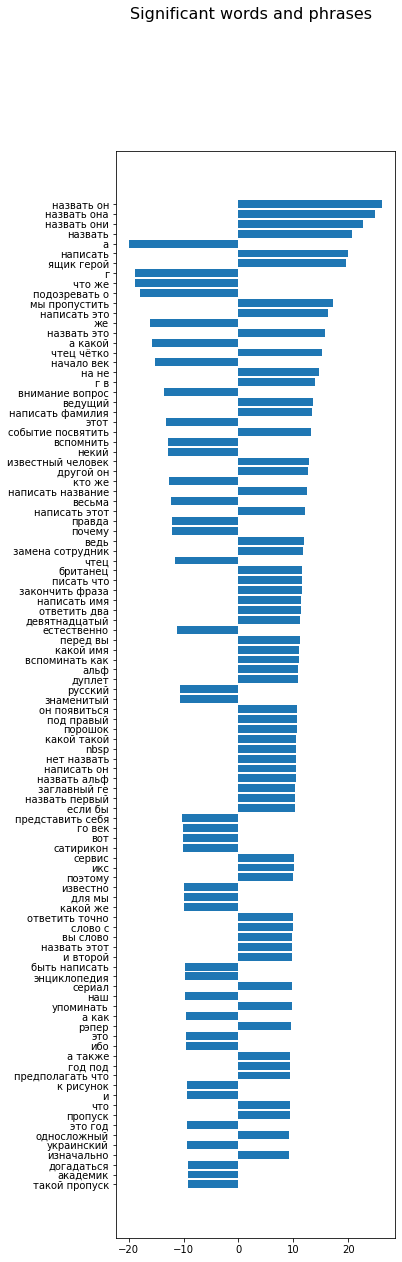

In [41]:
show_significant(significant, top=100)

Let's interpret our results. Ngrams with big positive coefficients indicate that they probably belong to a later question and vice versa. It means that expressions such as 
- 'назовите его/её/их' ('name him/her/them'), 
- 'мы пропустили' ('we skipped \[a word\]'), 
- 'напишите/назовите это' ('write down this \[word\]'), 
- ИКС ('X'), 
- 'пропуск' ('blank') 
- (and also 'рэпер' (rapper) and 'сериал' (series)) 

are more common in modern questions, whereas 
- 'что/кто/какой же' (what/who/which is), 
- 'внимание, вопрос' ('attention, the question'), 
- 'почему' ('why'), 
- 'известно' ('it's known') 

were more frequent in 2000-s. Therefore we can conclude that at first a competitive version of ChGK imitated the TV version, but now it's becoming more independent and is preferring its own words and phrases.

Now let's start with Deep Learning. We'll use the transformers package of Huggingface

In [42]:
!pip install ipywidgets widgetsnbextension pandas-profiling transformers datasets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


We'll load language model pretrained by Sberbank on the Russian corpora and fine-tune it on our dataset.

In [43]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_gen = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2")
model_gen = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2", pad_token_id=tokenizer_gen.eos_token_id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [44]:
tokenizer_gen.add_special_tokens({'bos_token': '[BOS]',
 'eos_token': '[EOS]',
 'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'})

7

In [45]:
model_gen.config.decoder_start_token_id = tokenizer_gen.cls_token_id
model_gen.config.eos_token_id = tokenizer_gen.sep_token_id
model_gen.config.pad_token_id = tokenizer_gen.pad_token_id
model_gen.config.sep_token_id = tokenizer_gen.sep_token_id
model_gen.config.vocab_size = tokenizer_gen.vocab_size
model_gen.resize_token_embeddings(len(tokenizer_gen))
model_gen.config.vocab_size

50265

In [46]:
from datasets import Dataset, Features, Value
import torch

In [47]:
def generate_text(model, beginning, args):  # generate a question given its beginning and a model
    input_ids = tokenizer_gen.encode(beginning, return_tensors='pt')
    output = model.generate(input_ids, **args)
    eos_n = [(output_i == tokenizer_gen.eos_token_id).nonzero() for output_i in output]
    return [tokenizer_gen.decode(output_i[:(eos_ni[0] if len(eos_ni) else len(output_i))], skip_special_tokens=False) for output_i, eos_ni in zip(output, eos_n)]

In [48]:
args = {'max_length': 50}
generate_text(model_gen, 'Известный человек, ', args)

['Известный человек, \nкоторый не может быть \nвсегда прав, \nне может быть \nвсегда прав. \nОн может быть \nвсегда прав, \nно не всегда \nвсегда прав.']

In [49]:
def df_to_ds(df: pd.DataFrame) -> Dataset:
    features = Features({'text': Value('string'), 'answer': Value('string')})
    ds_dict = {'text': df['Question'].to_list(),
               'answer': df['Answer'].to_list()
              }
    return Dataset.from_dict(ds_dict, features=features)

In [50]:
def tokenize_function(examples):
    return tokenizer_gen(examples["text"])

In [51]:
ds_train = df_to_ds(df_train)
ds_test = df_to_ds(df_test)

In [52]:
ds_train_tokenized = ds_train.map(tokenize_function, batched=True, remove_columns=["text", 'answer'])
ds_test_tokenized = ds_test.map(tokenize_function, batched=True, remove_columns=["text", 'answer'])

  0%|          | 0/54 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

We need to collate our texts to train a Language Model:

In [53]:
block_size = 128
def group_texts(examples):
    # Concatenate all texts.
    examples['input_ids'] = [example + [tokenizer_gen.eos_token_id,] for example in examples['input_ids']]
    examples['attention_mask'] = [example + [1,] for example in examples['attention_mask']]
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [54]:
batch_size = 16

In [55]:
lm_dataset_train = ds_train_tokenized.map(
    group_texts,
    batched=True,
    batch_size=batch_size
)
lm_dataset_test = ds_test_tokenized.map(
    group_texts,
    batched=True,
    batch_size=batch_size
)

  0%|          | 0/3360 [00:00<?, ?ba/s]

  0%|          | 0/934 [00:00<?, ?ba/s]

In [56]:
tokenizer_gen.decode(lm_dataset_train[1]["input_ids"], skip_special_tokens=False)

'-навсего Лунный Исследовательский Модуль, разработанный в рамках проекта "Аполло" и обладающий примитивным компьютером для решения узких навигационных задач. Так что просто нелепо ставить под сомнение авторство... Кого же?[EOS]Считается, что автору классического японского романа "Повесть о ГЭндзи" было слишком печально писать о смерти любимого героя. Так или иначе, но глава под названием "Сокрытие в облаках" имеет нечто общее с главой другого произведения, одно из англоязычных названий которого содержит слово "line" [лайн]. Назовите это второе произведение.[EOS]Джером Клапка Джером'

In [57]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="test_trainer",
    save_strategy='steps',                                  
    save_steps=200, 
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    optim="adamw_torch",
)

In [58]:
from transformers import Trainer
trainer = Trainer(
    model=model_gen,
    args=training_args,
    train_dataset=lm_dataset_train,
    eval_dataset=lm_dataset_test,
)

In [59]:
# trainer.train(resume_from_checkpoint=True)

In [60]:
my_model_path = "mary905el/rugpt3large_neuro_chgk"
# from huggingface_hub import notebook_login
# notebook_login()
# model_gen.push_to_hub(my_model_path)
# tokenizer_gen.push_to_hub(my_model_path)

In [61]:
tokenizer_gen = AutoTokenizer.from_pretrained(my_model_path)
model_gen = AutoModelForCausalLM.from_pretrained(my_model_path)

loading file mary905el/rugpt3large_neuro_chgk\vocab.json
loading file mary905el/rugpt3large_neuro_chgk\merges.txt
loading file mary905el/rugpt3large_neuro_chgk\tokenizer.json
loading file mary905el/rugpt3large_neuro_chgk\added_tokens.json
loading file mary905el/rugpt3large_neuro_chgk\special_tokens_map.json
loading file mary905el/rugpt3large_neuro_chgk\tokenizer_config.json
loading configuration file mary905el/rugpt3large_neuro_chgk\config.json
Model config GPT2Config {
  "_name_or_path": "mary905el/rugpt3large_neuro_chgk",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50263,
  "embd_pdrop": 0.1,
  "eos_token_id": 50261,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 2048,
  "n_embd": 1536,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 24,
  "n_positions": 2048,
  "pad_token_id": 50262,
  "r

OK, now let's test our model with different parameters, like in this article https://huggingface.co/blog/how-to-generate ! We'll start with greedy search:

In [62]:
from transformers import set_seed

set_seed(34)

In [63]:
args = {'max_length': 50}
generate_text(model_gen, 'Известный человек', args)

['Известный человек, родившийся в 1833 году, в одном из своих интервью сказал, что его предки были родом из Венгрии. Назовите этого человека.']

Beam search:

In [64]:
args = {
    'max_length': 50, 
    'num_beams': 5,
    'early_stopping': True,
       }
generate_text(model_gen, 'Известный человек', args)

['Известный человек вспоминал, что в детстве, когда он еще не умел читать и писать, ему часто приходилось перебирать ИХ. Назовите ИХ двумя словами, начинающимися на одну и ту же букву.']

Adding no_repeat_ngram_size:

In [65]:
args = {
    'max_length': 50, 
    'num_beams': 5,
    'early_stopping': True,
    'no_repeat_ngram_size': 2, 
       }
generate_text(model_gen, 'Известный человек', args)

['Известный человек вспоминал, что в детстве, когда он еще не умел читать и писать, он часто видел, как ЭТО ДЕЛАЮТ его сверстники. Назовите ЭТО двумя словами, начинающимися на одну и ту же букву.']

Sampling:

In [66]:
args = {
        'max_length': 70, 
        'do_sample': True,
        'top_k': 0,
        'no_repeat_ngram_size': 2, 
        'num_return_sequences': 5, 
        }
generate_text(model_gen, 'Известный человек', args)

['Известный человек жаловался в мемуарах на то, что Наполеон дразнил его "фрАнцузским крысиным королем". Собеседник неожиданно вспылил и сказал, чтобы "этот помещик английского происхождения убирался к черту". Назовите этого человека.',
 'Известный человек тоже мог стать летчиком, но уже в слишком юном возрасте и при весьма странных обстоятельствах. Назовите этого человека и его подвиг.',
 'Известный человек 155 лет назад очень опасался за свою жизнь, когда его, утомленного, полураздетого в холодную ночь, нашла служанка миссис Додд. Крестьянин вскоре женился на этой женщине, а в 1883 году она умерла. А от чего или от кого в ночь этого же дня в среднем умирают банкиры?',
 'Известный человек говорил о Франклине: "Я печальную новость узнал: скончался наш Франклин". Один из современников этого человека писал: "... он умер, начав свою карьеру на стойке бара и кончив свою...". Закончите мысль двумя словами латинского происхождения.',
 'Известный человек, родившийся в 1742 году в Литве, в пят

Sampling with lower temperature:

In [67]:
args = {'max_length': 70, 
        'do_sample': True,
        'temperature': 0.6,
        'top_k': 0,
        'no_repeat_ngram_size': 2, 
        'num_return_sequences': 5, 
        }
generate_text(model_gen, 'Известный человек', args)

['Известный человек, шутя, говорил, что в городе его знают в лицо, и в каждом доме у него есть свой ИКС. Назовите ИХ двумя словами.',
 'Известный человек вспоминал, что наиболее сильное впечатление на него произвел в детстве концертный рояль фирмы "Гайдн". С тех пор он и посвятил себя музыке. Назовите этого человека.',
 'Известный человек, живший в шестнадцатом веке, утверждал, что ОНИ не причиняют боли. Назовите ИХ.',
 'Известный человек был большим поклонником этого растения. В его честь была названа одна из улиц города, а в России им интересовались еще в советские времена. А вот о его соотечественнике, прославившемся в конце XIX века, этого сказать нельзя. Зато мы можем с уверенностью сказать, что в начале XX века он прославился еще более знаменитым',
 'Известный человек рассказывает, что в детстве, когда он еще учился в школе, на уроках изо стран мира ему показывали диафильмы с изображениями различных животных. Прослушайте цитату из этого рассказа: "А вот этот, с бородкой, - африка

Top-k sampling: 

In [68]:
args = {'max_length': 70, 
        'do_sample': True,
        'top_k': 50,
        'num_return_sequences': 5,
      }
generate_text(model_gen, 'Известный человек', args)

['Известный человек пишет, что, по его мнению, в "НЕЙ" всегда должно присутствовать семь - три сверху, три снизу и еще один в середине. Назовите ЕЕ тремя словами.',
 'Известный человек вспоминает, что был еще такой анекдот: "Идет по пустыне Рабинович. Навстречу ему другой Рабинович, уставший, голодный. Растерялся Рабинович. Стоит он посреди пустыни, и тут он услышал...". Что?',
 'Известный человек вспоминал в связи с этим: "Оказывается, иногда в детстве я неплохо рисовал, хотя и не любил это занятие". Назовите этого известного человека.',
 'Известный человек не хотел, чтобы его воспринимали как идиота или неудачника, поэтому однажды сказал: "Когда мне было 16, я прочитал все, кроме ЭТОГО". Назовите ЭТО.',
 'Известный человек, желая обратить на себя внимание журналистов, однажды переоделся во фрак и даже надел цилиндр. Однако он сразу же вызвал у них ощущение неловкости, так как старался произвести именно такое впечатление, причем, заметим, делал он это не только публично. Что он хотел 

Top-p sampling:

In [69]:
args = {'max_length': 70, 
        'do_sample': True,
        'top_p': 0.7,
        'top_k': 0,
        'num_return_sequences': 5,
      }
generate_text(model_gen, 'Известный человек', args)

['Известный человек в разговоре с коллегой назвал этот способ первым. Назовите другой, довольно старый, способ, которым можно назвать этот.',
 'Известный человек писал: "За многие годы у меня было несколько видений, которые казались разными. Во время одного из видений я увидел два ряда солдат, идущих по дороге и поднимающих вверх большой палец. И тут я вспомнил одно слово, которое знал по русскому языку, и понял, что это за слово. Назовите это слово',
 'Известный человек, сравнивая ИХ с русскими иконами, образно говорил: "ОНИ написаны кровью мучеников, а кровью мучеников написана и ИХ кровь". Назовите ИХ двумя словами.',
 'Известный человек, например, говорил, что в юности видел, как ОН размахивал руками, подобно мельничному колесу. ОНО было построено в 1835 году. Назовите ЕГО.',
 'Известный человек вспоминал, как, вернувшись в город после длительного пребывания в горах, шел по улице и с ужасом наблюдал, как ИКСЫ становились все больше и больше. Назовите ИКСЫ словом латинского происхож

Combination:

In [70]:
args = {'max_length': 70, 
        'do_sample': True,
        'top_p': 0.8,
        'top_k': 50,
        'temperature': 0.7,
        'no_repeat_ngram_size': 2, 
        'num_return_sequences': 5
      }
generate_text(model_gen, 'Известный человек', args)

['Известный человек, говоря о НЕЙ, упоминает, что на ней не было ни одного животного. Назовите ЕЕ.',
 'Известный человек говорил, что в его жизни было три ИКСА. Один из них - это то, с чем он родился. Назовите ИХ двумя словами.',
 'Известный человек говорил, что у него есть три любимых занятия: писать книги, охотиться и есть. Назовите это занятие максимально точно.',
 'Известный человек, родившийся в 1823 году, говорил: "Я не знаю, что такое "идеал", но я знаю что-то такое, чего никто не понимает". Что же это?',
 'Известный человек, занимавшийся этим, был, по одной из версий, тезкой другого человека, ставшего в 1846 году генерал-губернатором Западной Сибири. Назовите этого человека.']

And now let's train our model to answer the questions! Nah, I don't think it'll work well, it's pretty hard even for people (especially not ChGK-players), but we should try. GPT-2 model doesn't suit this task, so we'll choose another one. In Huggingface, there is a task of 'Question Answering'. It sounds like our case, but, actually, it's a task of finding the answer in the text of the question, and for ChGK it's not always possible (however, it happens sometimes). Therefore, we'll try Text2Text generation. Once again, let's use a Sberbank model.

In [71]:
from transformers import AutoModelForSeq2SeqLM, T5Tokenizer

model_ans = AutoModelForSeq2SeqLM.from_pretrained("sberbank-ai/ruT5-base")
tokenizer_ans = T5Tokenizer.from_pretrained("sberbank-ai/ruT5-base")

loading configuration file https://huggingface.co/sberbank-ai/ruT5-base/resolve/main/config.json from cache at C:\Users\mpiliugina/.cache\huggingface\transformers\15f5f9138b337892ef8dadfab622952847d6eb4b5985a825847fbaa18538bae9.d9b947fcfcea30df5eb71effa3afe0a2e3da3535463b97a14c3c0401ac680b99
Model config T5Config {
  "_name_or_path": "sberbank-ai/ruT5-base",
  "_num_labels": 2,
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 2,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_

In [72]:
input_ids = tokenizer_ans("Кто это?", return_tensors="pt").input_ids
tokenizer_ans.decode(model_ans.generate(input_ids)[0])

'<pad> <extra_id_0> ) ) ).. ) )<extra_id_26> ть тьть'

In [73]:
max_source_length = 128
def tokenize_ans_ds(ds):
    text_ = tokenizer_ans(ds['text'], 
        padding="max_length",
        max_length=max_source_length,
        truncation=True,
        return_tensors="pt",)
    answer_ = tokenizer_ans(ds['answer'],
        padding="max_length",
        max_length=max_source_length,
        truncation=True,
        return_tensors="pt",)
    return {'input_ids': list(text_.input_ids), 'attention_mask': list(text_.attention_mask), 'labels': list(answer_.input_ids)}

In [74]:
ans_train_tokenized = ds_train.map(tokenize_ans_ds, batched=True, remove_columns=["text", 'answer'])
ans_test_tokenized = ds_test.map(tokenize_ans_ds, batched=True, remove_columns=["text", 'answer'])

  0%|          | 0/54 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

In [75]:
batch_size = 16
training_args_ans = TrainingArguments(
    output_dir="ans_trainer",
    save_strategy='steps',                                  
    save_steps=200, 
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    optim="adamw_torch",
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [76]:
trainer = Trainer(
    model=model_ans,
    args=training_args_ans,
    train_dataset=ans_train_tokenized,
    eval_dataset=ans_test_tokenized,
)

In [77]:
# trainer.train(resume_from_checkpoint=True)

In [78]:
my_model_path_ans = "mary905el/ruT5_neuro_chgk_answering"
# from huggingface_hub import notebook_login

# notebook_login()
# model_ans.push_to_hub(my_model_path_ans)
# tokenizer_ans.push_to_hub(my_model_path_ans)

model_ans = AutoModelForSeq2SeqLM.from_pretrained(my_model_path_ans)
tokenizer_ans = T5Tokenizer.from_pretrained(my_model_path_ans)

loading configuration file mary905el/ruT5_neuro_chgk_answering\config.json
Model config T5Config {
  "_name_or_path": "mary905el/ruT5_neuro_chgk_answering",
  "_num_labels": 2,
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 2,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_len

Now we can finally answer to our 'questions'!

In [79]:
args = {'max_length': 70, 
        'do_sample': True,
        'temperature': 0.6,
        'top_k': 0,
        'no_repeat_ngram_size': 3, 
        'num_return_sequences': 5, 
        }
args_ans = {
        'do_sample': True,
        'temperature': 0.8,
        }
texts = generate_text(model_gen, 'В известном произведении', args)
for text in texts:
    input_ids = tokenizer_ans(text, return_tensors="pt").input_ids
    outputs = model_ans.generate(input_ids, **args_ans)
    print('Question:', text)
    print('Answer: ', tokenizer_ans.decode(outputs[0], skip_special_tokens=True))

Question: В известном произведении ОНА названа "дивным, но не безобразным чудом". Назовите ЕЕ.
Answer:  Попкорн.
Question: В известном произведении на вопрос, кто из них сильнее, в шутку отвечают, что они все равны, но сильнейший - он. Назовите этого человека.
Answer:  Иисус Христос.
Question: В известном произведении описывается, как один из НИХ, увидев, что его товарищ погиб, воскликнул: "О, рука, рука! Ты отомщена!". Назовите ИХ двумя словами.
Answer:  Голубиные перья.
Question: В известном произведении, написанном в конце XIX века, заглавный герой - русский дворянин - говорит: "Времена меняются. Английский язык стал языком чиновников, итальянский - языком богачей, немецкий - языком пролетариата, французский - языком армии, итальянский же - языком священников". Назовите автора этого произведения.
Answer:  [Александр Сергеевич] Пушкин.
Question: В известном произведении описан такой эпизод. Приехавший в гости к герою своей повести известный человек застал его за чтением романа, назва

Some examples:
* Question: В известном произведении описывается, что в бою у реки Парма солдаты противника, которых было много, бежали, оставив на поле боя множество трупов. В связи с этим автор упоминает ЕЕ. Назовите ЕЕ двумя словами.
** Answer:  Слепая рука.
* Question: В известном произведении ОН, по словам автора, "стоял, как часовой у кремлевской стены, и ждал, когда часовой поумнеет". Назовите ЕГО.
** Answer:  Ягненок \[Иван\].
* Question: В известном произведении герой, чтобы не умереть с голоду, ДЕЛАЕТ ЭТО. Назовите ЭТО двумя словами.
** Answer:  Завязывает шнурки.
* Question: В известном произведении есть такой эпизод. "Мы сидели в саду на скамейке, - пишет автор, - и я читал эту книгу, а она лежала у меня на коленях". Далее он называет двух персонажей, чьим прототипом являются оба персонажа. Назовите обоих.
** Answer:  "Девушка с веслом" и "Золотой жук".
* Question: В известном произведении описывается, как ОН, положив руки на бока, пускает коня вскачь, а за НИМ следует вереница всадников. Назовите ЕГО.
** Answer:  \[Иван\] Грозный.

Not so bad! Our network even can sometimes 'hold the form' - if it's asked to 'name her', it answers with a feminine, if to 'name them' - plural, etc. Not every chgk-team is able to do it!

You can test and download the models here:  
* https://huggingface.co/mary905el/ruT5_neuro_chgk_answering  
* https://huggingface.co/mary905el/rugpt3large_neuro_chgk  

My telegram bot: https://t.me/chgk_neuro_bot 